In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna import Trial
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(
    "../input/2s/15day_0201_0215.csv", usecols=["ds", "y"], parse_dates=["ds"]
)
print(df.shape)
df["ds"] = pd.to_datetime(df["ds"])
df.head()

(648000, 2)


,ds,y
0,2021-02-01 19:00:00,12.0
1,2021-02-01 19:00:02,7.0
2,2021-02-01 19:00:04,1.0
3,2021-02-01 19:00:06,16.0
4,2021-02-01 19:00:08,19.0


In [3]:
df.tail()

,ds,y
647995,2021-02-16 18:59:50,19.0
647996,2021-02-16 18:59:52,19.0
647997,2021-02-16 18:59:54,19.0
647998,2021-02-16 18:59:56,19.0
647999,2021-02-16 18:59:58,19.0


In [4]:
train = df[df['ds'] < '2021-2-10']
valid = df[df['ds'] >= '2021-2-10'].copy()
valid["ds"] = valid["ds"].astype(str).map(lambda x: x[:16])
valid["ds"] = pd.to_datetime(valid["ds"])
valid = valid.groupby("ds")["y"].agg("mean").reset_index()
valid

,ds,y
0,2021-02-10 00:00:00,17.002904
1,2021-02-10 00:01:00,15.713705
2,2021-02-10 00:02:00,14.424506
3,2021-02-10 00:03:00,13.135308
4,2021-02-10 00:04:00,11.846109
...,...,...
9775,2021-02-16 18:55:00,10.900000
9776,2021-02-16 18:56:00,10.500000
9777,2021-02-16 18:57:00,11.233333
9778,2021-02-16 18:58:00,19.000000


In [5]:
def objective(trial: Trial) -> float:
    params = {
        "epochs": trial.suggest_categorical("epochs", [30, 50, 100]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512]),
        "num_hidden_layers": trial.suggest_int("num_hidden_layers", 1, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1),
        "changepoints_range": trial.suggest_discrete_uniform(
            "changepoints_range", 0.8, 0.95, 0.001
        ),
        "n_changepoints": trial.suggest_int("n_changepoints", 20, 35),
#         "growth": "logistic",
#         "seasonality_mode": "additive",
        "yearly_seasonality": False,
        "weekly_seasonality": True,
        "daily_seasonality": True,
        "loss_func": "MSE",
    }
    # fit_model
    m = NeuralProphet(**params)
    m.fit(train, freq="1min")
    future = m.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)

    forecast = m.predict(future)
    valid_forecast = forecast[forecast.y.isna()]
    val_rmse = mean_squared_error(valid_forecast.yhat1, valid.y, squared=False)

    return val_rmse

In [6]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=10)

[I 2021-05-17 09:47:27,512] A new study created in memory with name: no-name-ed961833-fe01-481c-a4e3-abdafef07091
Epoch[50/50]: 100%|██████████| 50/50 [03:26<00:00,  4.13s/it, MSELoss=0.118, MAE=10.5, RegLoss=0]
[I 2021-05-17 09:50:58,968] Trial 0 finished with value: 11.667542007468528 and parameters: {'epochs': 50, 'batch_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.07109918520180851, 'changepoints_range': 0.803, 'n_changepoints': 35}. Best is trial 0 with value: 11.667542007468528.
Epoch[30/30]: 100%|██████████| 30/30 [02:41<00:00,  5.39s/it, MSELoss=0.118, MAE=10.5, RegLoss=0]
[I 2021-05-17 09:53:45,601] Trial 1 finished with value: 11.859444582628814 and parameters: {'epochs': 30, 'batch_size': 128, 'num_hidden_layers': 4, 'learning_rate': 0.01480989220455214, 'changepoints_range': 0.8440000000000001, 'n_changepoints': 25}. Best is trial 0 with value: 11.667542007468528.
Epoch[50/50]: 100%|██████████| 50/50 [03:41<00:00,  4.44s/it, MSELoss=0.118, MAE=10.5, RegLoss=0]
[I 

In [19]:
prophet_params = {'batch_size': 64, 'num_hidden_layers': 1, 'learning_rate': 0.020402303379495376, 'changepoints_range': 0.806, 'n_changepoints': 25}
prophet_params["epochs"] = 30
prophet_params["loss_func"] = "MSE"
prophet_params["weekly_seasonality"] = True
prophet_params["daily_seasonality"] = True
prophet_params["yearly_seasonality"] = False

In [20]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)

In [21]:
metrics = model.fit(train, freq="1min")

Epoch[30/30]: 100%|██████████| 30/30 [04:30<00:00,  9.00s/it, MSELoss=0.118, MAE=10.5, RegLoss=0]


In [22]:
future = model.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)
forecast = model.predict(future)

In [23]:
valid_forecast = forecast[forecast.y.isna()]
val_rmse = mean_squared_error(valid_forecast.yhat1, valid.y, squared=False)

In [24]:
print(val_rmse)

11.51051481044486


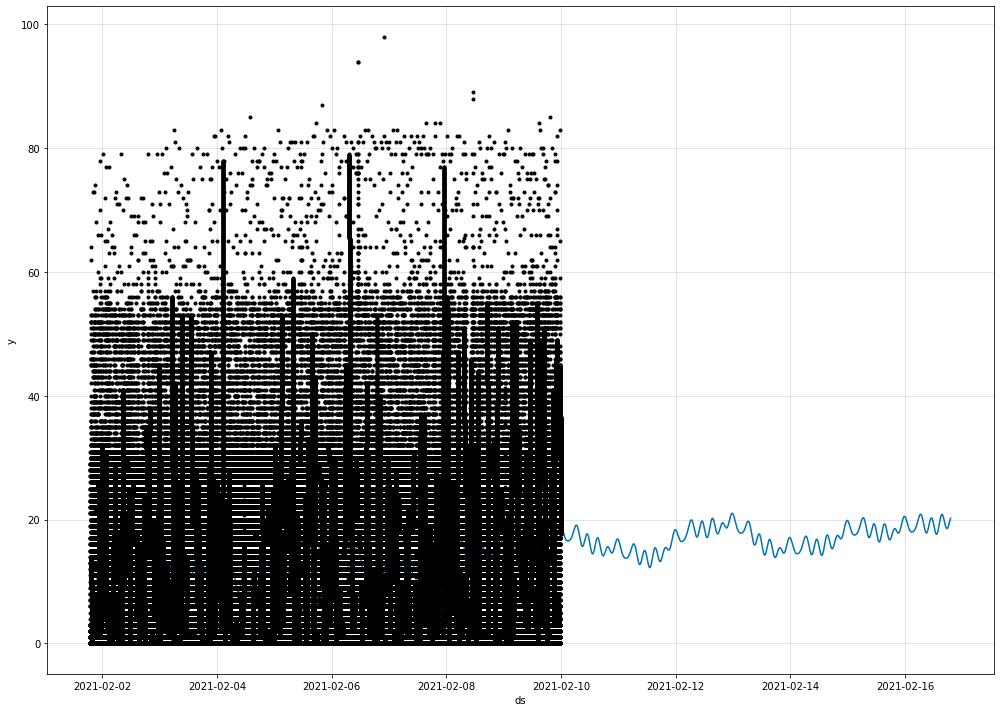

In [25]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()

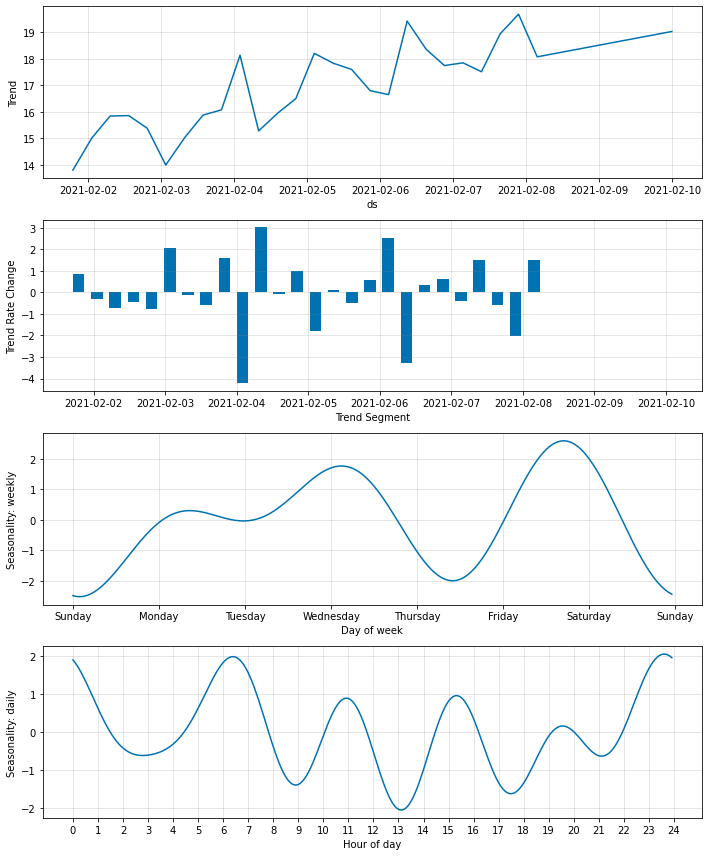

In [12]:
# fig_comp = m.plot_components(forecast)
m = model.highlight_nth_step_ahead_of_each_forecast(1) # temporary workaround to plot actual AR weights
fig_param = model.plot_parameters()

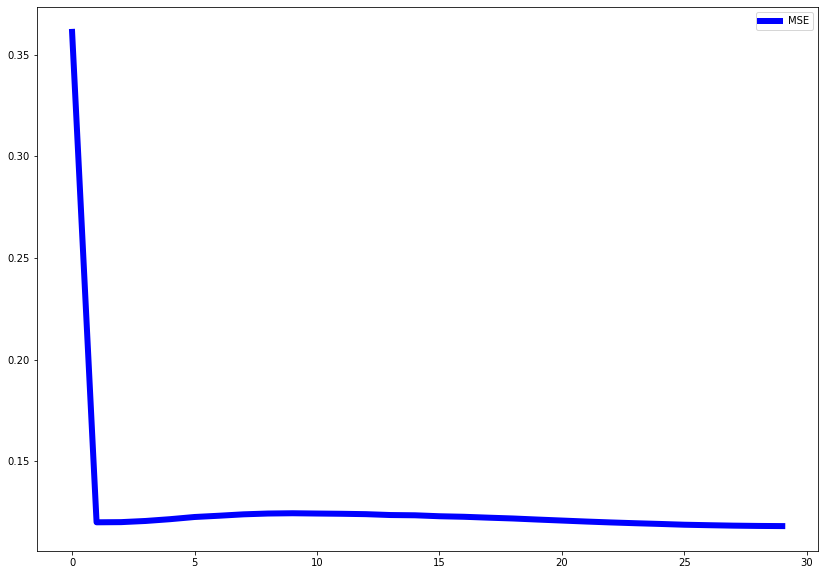

In [13]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metrics["MSELoss"], 'b', linewidth=6, label="MSE")  
plt.legend()

In [14]:
model = NeuralProphet(**prophet_params)
metrics = model.fit(df, freq="1min")
future = model.make_future_dataframe(df, periods=120, n_historic_predictions=True)
forecast = model.predict(future)

Epoch[30/30]: 100%|██████████| 30/30 [06:38<00:00, 13.27s/it, MSELoss=0.123, MAE=11, RegLoss=0]  


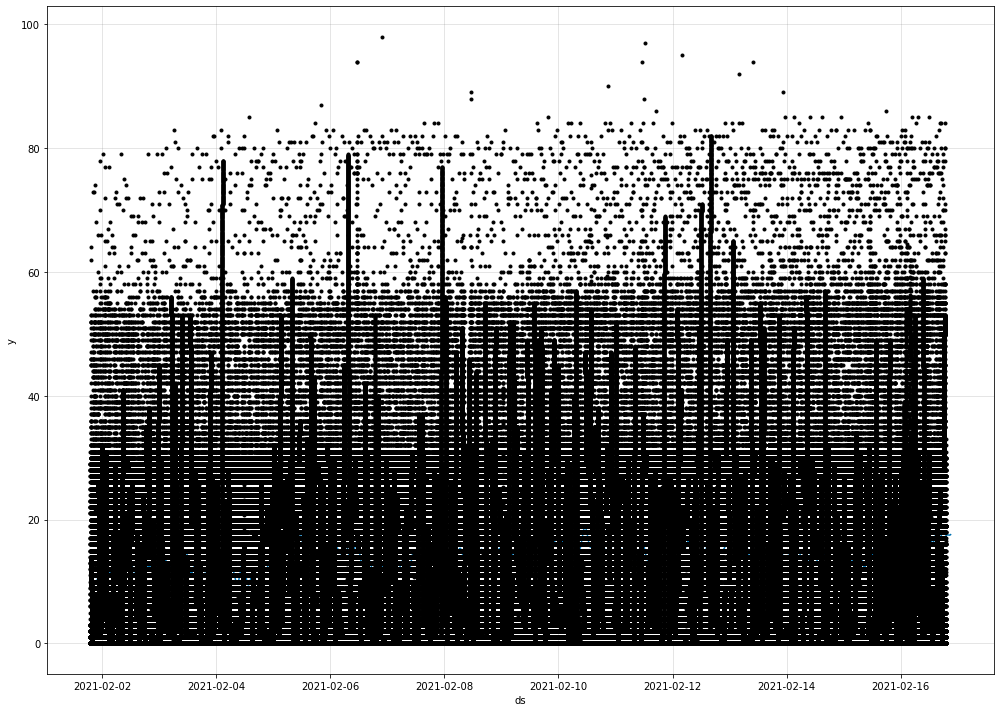

In [15]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()